<a href="https://colab.research.google.com/github/Devdeep-J-S/Python/blob/master/Seg_uncertainty_KDD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uncertainty in image segmentation: Towards safer usage of AI in healthcare
# Nabeel Seedat

## Introduction

 - Deep learning has enabled outstanding performance in many computer vision tasks, including medical image analysis [6].
 - However, in healthcare it is imperative that neural networks provide estimates of uncertainty [1, 8, 10, 12]. This ties heavily into AI safety which is a increasingly important area. Moreover, understanding where the model is both certain and uncertain in it's predicitions. This can allow for human in the loop intervention for areas of high uncertainty.

 - Blood vessel segmentation is used for automated detection and analysis of vasculature in the diagnosis, screening and treatment of diseases such as diabetes, hypertension and arteriosclerosis [13].

 - We will use the Digital Retinal Images for Vessel Extraction (DRIVE) dataset for evaluation [13].

 - We solve the problem of the lack of uncertainty for such a critical task that can impact lives using a Bayesian Neural Networks (BNNs)
 - Inference using Bayes Rule given by the equation below is expensive, due to the cost in computing the marginal likelohood
 \begin{equation} \label{bayes}
P(\theta|x,y)=\frac{P(x,y|\theta)P(\theta)}{\int P(y|x,\theta)P(\theta)d\theta }
\end{equation}

 - Hence, approximate inference like Markov Chain Monte Carlo [15] or Variational Inference [14] are used, however they are computationally expensive for neural networks.
 - Monte Carlo Dropout (MCD)  [1] is a method proposed to address this by apply dropout at inference/test time. i.e. we do multiple stochastic forward passes through the network


 - For this work we thus propose a model that incorporates uncertainty into segmentation using a U-Net
 - A U-Net neural network architecture is widely used for image segmentation: Gold standard network for biomedical image segmentation [11]

 - We compute 4 different uncertainty measures:

    (1) Predictive Entropy: which is widely used in information theory
has been argued to be a good measure to evaluate uncertainty, where a higher entropy corresponds to a greater amount of uncertainty [7]. This measure is given by:
\begin{equation}\label{exent}
    H=-\sum_{y \in Y}^{} P(y|x)logP(y|x)
\end{equation}
where $P(y|x)$ is the softmax output of the network for an input $x$.

(2) Mutual Information:
 is the information gain related to the model parameters for the dataset if we see a label $y$ for an input $x$. This is given as the  predictive entropy minus the expected entropy. i.e.,
\begin{equation}\label{mi}
    I = H[P(y | x,D)]-\mathbb{E}_{p(w|D)}H[P(y|x,w)].
\end{equation}

(3) Aleatoric Uncertainty:
 captures the inherent noise (stochasticity) in the data [2,4,12]. Hence, increasing the dataset size will not impact uncertainty. Thus, for mutilated data the uncertainty should be high. Aleatoric uncertainty is calculated using [5]:
\begin{equation}\label{alea}
   \frac{1}{T}\sum_{t=1}^{T}diag(\hat{p_{t}})-\hat{p_{t}}\hat{p_{t}}^{T}
\end{equation}
where, $\hat{p_{t}} = $ softmax $(f_{w_{t}}(x^{*})$).

(4) Epistemic Uncertainty:
is the inherent model uncertainty. When inputs are similar to the training data there will be lower uncertainty, whilst data that is different should have a higher epistemic uncertainty [2,4,12]. Epistemic uncertainty is given by [5]
\begin{equation}\label{epi}
   \frac{1}{T}\sum_{t=1}^{T}(\hat{p_{t}}-\bar{p_{t}})(\hat{p_{t}}-\bar{p_{t}})^{T}
\end{equation}
where  $ \bar{p_{t}}$  = $\frac{1}{T}\sum_{t=1}^{T}\hat{p_{t}}$.

 Finally, we then aim to determine what's the best threshold for uncertainty to refer predictions to a medical professional. This will ensure high performance as a doctor would then examine cases with high uncertainty.

 SUMMARY:
 We combine segmentation using a U-Net with MC dropout to add uncertainty to predictions in the healthcare domain. This uncertainty is leveraged to enable referrals of uncertain cases and promotes safer usage of AI.

# Framework overview

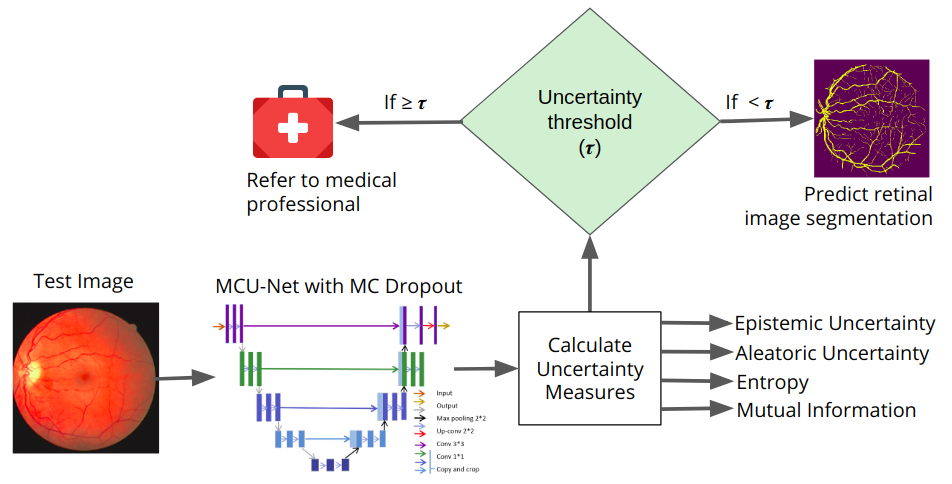

# Import dependancy packages

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os, glob
import pandas as pd
import zipfile
from skimage.external import tifffile
from skimage.io import imread
from skimage.transform import resize

# Load the drive dataset


The dataset contains 40 labelled images (20 train and 20 test) to evaluate segmentation of blood vessels in retinal images.

In [ ]:
# extract data stored in the zip files - Drive dataset
with zipfile.ZipFile("DRIVE_retinal_image_data.zip","r") as unzip:
    unzip.extractall("data")

In [ ]:
def getIO(images,labels):
    '''

    Reads data into x (images) and y (labels - annotation maps)

    '''
    sorted_images = sorted(glob.glob(images))
    sorted_labels = sorted(glob.glob(labels))

    x_data = np.array([tifffile.imread(img) for img in sorted_images])
    y_data = np.array([imread(label) for label in sorted_labels])

    return x_data, np.expand_dims(y_data, -1) # add channels dimension

In [ ]:
trainImgDir='data/DRIVE/training/images/*.tif'
trainlabelDir='data/DRIVE/training/labels/*_manual1.gif'

testImgDir='data/DRIVE/test/images/*.tif'
testlabelDir='data/DRIVE/test/labels/*_manual1.gif'

x_train,y_train=getIO(trainImgDir,trainlabelDir)
x_test,y_test=getIO(testImgDir,testlabelDir)


/usr/local/lib/python3.6/dist-packages/skimage/external/tifffile/tifffile.py:2618: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


# Preprocessing the data

(1) Image formatting - ensure all pixels floats and normalize between 0-1 and
(2) Data augmentation

In [ ]:
# Scale the pixels between 0 and 1
maxVal,minVal=255,0
x_train = (x_train.astype(np.float32)-minVal)/(maxVal-minVal)
x_test = (x_test.astype(np.float32)-minVal)/(maxVal-minVal)

y_train = (y_train.astype(np.float32)-minVal)/(maxVal-minVal)
y_test = (y_test.astype(np.float32)-minVal)/(maxVal-minVal)

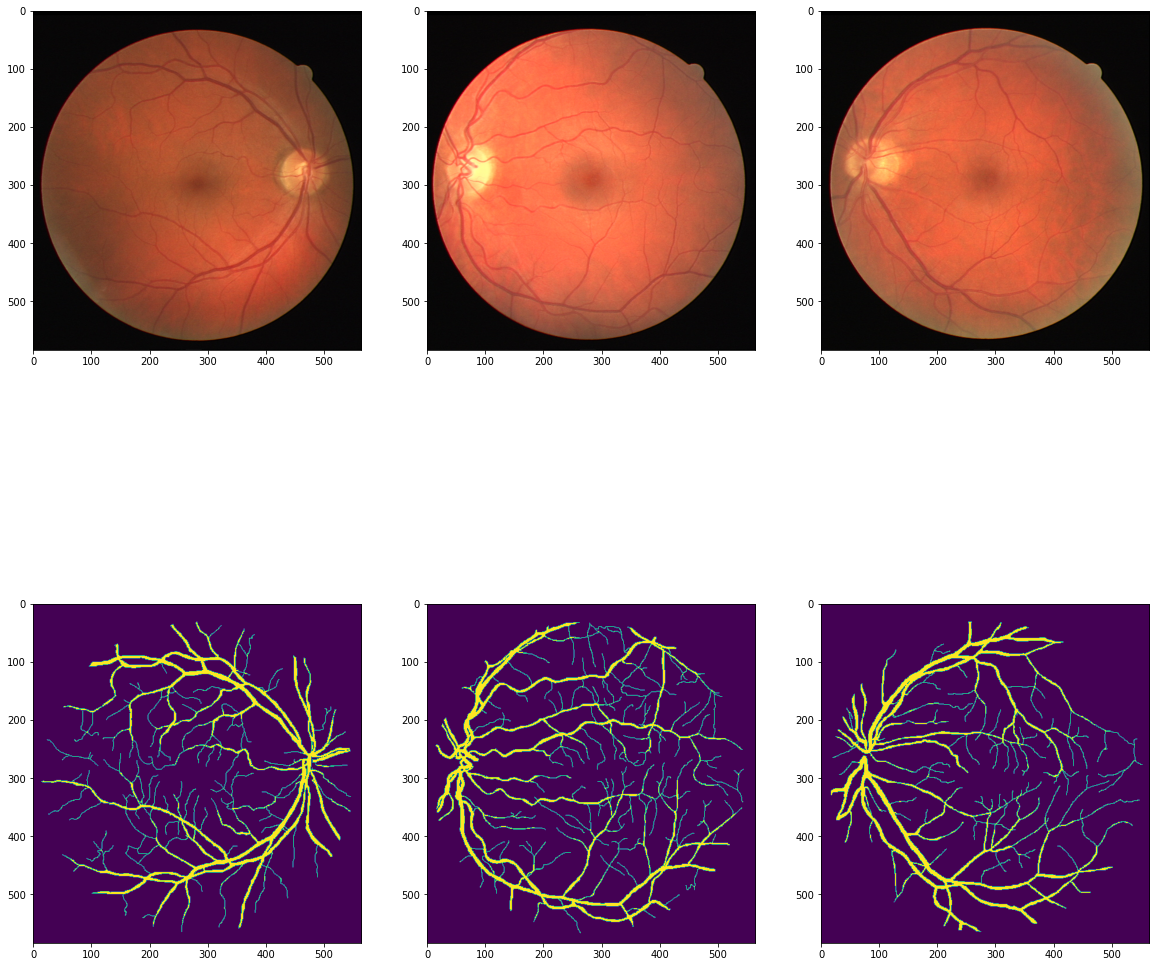

In [ ]:
#Visualize a few images and the true segmentation maps
fig, ax = plt.subplots(2,3, figsize=(20,20))
ax[0,0].imshow(x_train[0])
ax[1,0].imshow(np.squeeze(y_train[0]))
ax[0,1].imshow(x_train[1])
ax[1,1].imshow(np.squeeze(y_train[1]))
ax[0,2].imshow(x_train[2])
ax[1,2].imshow(np.squeeze(y_train[2]))

Given the small dataset, we augment the data by training the network on 1000 random patches from the training set and evaluate using 100 random patches from the test set.

In [ ]:
def augment_i(x, y, size=(48,48)):
    '''Augment the small dataset: by doing random patch samples of the images '''

    #assert x.shape[:2] == y.shape[:2]
    dim0=x.shape[0]
    dim1=x.shape[1]
    dim2=x.shape[2]
    # get image sample
    image_index = np.random.randint(0, dim0)
    # get x and y dimensions
    min_h = np.random.randint(0, x.shape[1]-size[0])
    max_h = min_h+size[0]
    min_w = np.random.randint(0, x.shape[2]-size[1])
    max_w = min_w+size[1]
    # extract snippet
    im_x = x[image_index, min_h:max_h, min_w:max_w, :]
    im_y = y[image_index, min_h:max_h, min_w:max_w, :]

    # rotate
    number_rotaions = np.random.randint(0,4)
    im_x = np.rot90(im_x, k=number_rotaions, axes=(0,1))
    im_y = np.rot90(im_y, k=number_rotaions, axes=(0,1))

    # flip left-right, up-down
    if np.random.random() < 0.5:
        lr_ud = np.random.randint(0,2) # flip up-down or left-right?
        im_x = np.flip(im_x, axis=lr_ud)
        im_y = np.flip(im_y, axis=lr_ud)

    return (im_x, im_y)

def augment_data(x, y, N, size):
    augmented_data=[]
    for i in range(N):
        augmented_data.append(augment_i(x, y, size))

    x_augment = np.array([i[0] for i in augmented_data])
    y_augment = np.array([i[1] for i in augmented_data])
    return (x_augment, y_augment)

Create augmented train and test data via patch augmentation

In [ ]:
X_train, Y_train = augment_data(x_train, y_train, N=1000, size=(96,96))
X_test, Y_test = augment_data(x_train, y_train, N=1000, size=(96,96))

Visualize the patch and ground truth segmentation

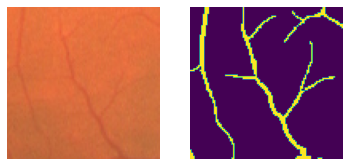

In [ ]:
n = np.random.randint(0, X_train.shape[0])
fig, ax = plt.subplots(1,2)
ax[0].imshow(X_train[n])
ax[1].imshow(np.squeeze(Y_train[n]))
for a in ax: a.axis('off')


# Define the U-Net Architecture

We perform evaluation with a standard U-Net initialized using He Normal Initialization. Approximate Bayesian inference is performed using Monte Carlo dropout, with dropout probability of 0.25.

In [ ]:
from keras.layers import Input, Dropout, Activation, Add, BatchNormalization, Conv2D, Concatenate, UpSampling2D
from keras.models import Model

'''
Hyper-parameters
'''
drop_prob=0.25 # Dropout probability
weight_init='glorot_normal'  # weight initialization
activationFunc='elu' # activation function
strides=1
pad='same'

def UNet(N_filters=32):
    '''

    Define the U-Net Architecture which will perform semantic segmentation

    '''
    def Conv_BN_Dropout(n_filters, kernel_size, strides, inputs):
        '''

        Function which performs the convolution, batch norm and dropout operations in every layer

        '''
        x = Conv2D(n_filters, (1,1), strides=1, padding=pad, kernel_initializer=weight_init,activation=activationFunc)(inputs)
        x = Conv2D(n_filters, kernel_size, strides=strides, padding=pad, kernel_initializer=weight_init,activation=activationFunc)(x)
        x = BatchNormalization()(x)
        x = Dropout(rate=drop_prob)(x, training=True) # training + test-time dropout!
        return x

    '''
    DEFINITION OF THE U-NET
    '''
    inputs = Input((None, None, 3))

    '''
    ENCODER - like a conventional CNN
    '''

    layer1 = Conv_BN_Dropout(N_filters,  (5, 5), (1,1), inputs)
    layer2 = Conv_BN_Dropout(2*N_filters,  (5, 5), (2,2), layer1)
    layer3 = Conv_BN_Dropout(4*N_filters, (3, 3), (2,2), layer2)
    layer4 = Conv_BN_Dropout(8*N_filters, (3, 3), (2,2), layer3)
    layer5 = Conv_BN_Dropout(16*N_filters, (3, 3), (2,2), layer4)


    '''
    DECODER - Up convolution with skips
    '''
    skip4 = Concatenate(axis=-1)([UpSampling2D(size=(2,2))(layer5), layer4])#copy with layer 4
    layer6 = Conv_BN_Dropout(8*N_filters, (3, 3), (1,1), skip4)

    skip3 = Concatenate(axis=-1)([UpSampling2D(size=(2,2))(layer6), layer3]) #copy with layer 3
    layer7 = Conv_BN_Dropout(4*N_filters, (3, 3), (1,1), skip3)

    skip2 = Concatenate(axis=-1)([UpSampling2D(size=(2,2))(layer7), layer2])#copy with layer 2
    layer8 = Conv_BN_Dropout(2*N_filters, (3, 3), (1,1), skip2)

    skip1 = Concatenate(axis=-1)([UpSampling2D(size=(2,2))(layer8), layer1])#copy with layer 1
    layer9 = Conv_BN_Dropout(N_filters, (3, 3), (1,1), skip1)

    output = Conv2D(1, (1, 1), strides=(1,1), activation='sigmoid', name='output')(layer9)

    return Model(inputs=inputs, outputs=output)

Using TensorFlow backend.


__Define evaluation metrics__

In [ ]:
from keras import backend as K
'''
EVALUATION METRICS using y_true and y_pred

- Dice coefficient
- Intersection Over Union (IOU)
- Precision
- Recall
'''

def dice_coefficient(y_true, y_pred):
    # flatten the image arrays for true and pred
    y_true=K.flatten(y_true)
    y_pred=K.flatten(y_pred[:,:,:,0])

    epsilon=1.0 # to prevent dividing by zero
    return (2*K.sum(y_true*y_pred)+epsilon)/(K.sum(y_true)+K.sum(y_pred)+epsilon)

def dice_loss(y_true, y_pred):
    return 1-dice_coefficient(y_true, y_pred)

def recall(y_true, y_pred):
    # flatten the image arrays for true and pred
    y_pred = K.flatten(y_pred)
    y_true = K.flatten(y_true)
    return (K.sum(y_true * y_pred)/ (K.sum(y_true) + K.epsilon()))

def precision(y_true, y_pred):
    y_pred = K.flatten(y_pred)
    y_true = K.flatten(y_true)
    return (K.sum(y_true * y_pred) / (K.sum(y_pred) + K.epsilon()))

def iou(y_true, y_pred):  #this can be used as a loss if you make it negative
    y_pred = K.flatten(y_pred)
    y_true = K.flatten(y_true)
    union = y_true + ((1 - y_true) * y_pred)
    return (K.sum(y_true * y_pred) + K.epsilon()) / (K.sum(union, axis=-1) + K.epsilon())

def iou_loss(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
    iou = (intersection + smooth) / ( union + smooth)
    return iou

Compile the model

In [ ]:
# DEFINE OPTIMZATION PARAMETERS AND COMPILE THE NETWORK
opt='adam'
loss_func='binary_crossentropy' #dice_loss
model = UNet(N_filters=16)
model.compile(optimizer=opt, loss=loss_func, metrics=['binary_accuracy', dice_coefficient, precision, recall, iou,iou_loss])

# Train the neural network

In [ ]:
loss = model.fit(X_train, Y_train, batch_size=4, epochs=10,shuffle=True,verbose=1,validation_data=(X_test, Y_test))

Train on 1000 samples, validate on 1000 samples
Epoch 1/10
1000/1000 [==============================] - 23s 23ms/step - loss: 0.4767 - binary_accuracy: 0.7965 - dice_coefficient: 0.3108 - precision: 0.2141 - recall: 0.6294 - iou: 0.1889 - iou_loss: 0.7787 - val_loss: 0.3368 - val_binary_accuracy: 0.8889 - val_dice_coefficient: 0.1686 - val_precision: 0.1518 - val_recall: 0.1974 - val_iou: 0.0927 - val_iou_loss: 0.8547
Epoch 2/10
1000/1000 [==============================] - 14s 14ms/step - loss: 0.2224 - binary_accuracy: 0.9351 - dice_coefficient: 0.4927 - precision: 0.4195 - recall: 0.6289 - iou: 0.3311 - iou_loss: 0.8997 - val_loss: 0.2043 - val_binary_accuracy: 0.9299 - val_dice_coefficient: 0.4671 - val_precision: 0.5220 - val_recall: 0.4273 - val_iou: 0.3095 - val_iou_loss: 0.9348
Epoch 3/10
1000/1000 [==============================] - 14s 14ms/step - loss: 0.1745 - binary_accuracy: 0.9407 - dice_coefficient: 0.5643 - precision: 0.5269 - recall: 0.6236 - iou: 0.3965 - iou_loss: 0.9

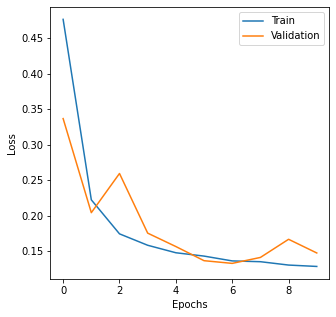

In [ ]:
'''
Plot the loss curves for train and validation
'''

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(loss.history['loss'])
ax.plot(loss.history['val_loss'])
ax.set_ylabel('Loss')
ax.set_xlabel('Epochs')
ax.legend(['Train', 'Validation'])



In [ ]:
'''
TEST EVALUATION

Evaluate the model performance on the test set
'''

score = model.evaluate(X_test, Y_test, verbose=1)
print(model.metrics_names)
print('Metrics:', score)

1000/1000 [==============================] - 3s 3ms/step
['loss', 'binary_accuracy', 'dice_coefficient', 'precision', 'recall', 'iou', 'iou_loss']
Metrics: [0.14725076651573182, 0.9471232891082764, 0.6296056509017944, 0.6503025889396667, 0.6111937761306763, 0.459759384393692, 0.9512924551963806]


# Experimental evaluation

The experimental evaluation involves:

(1) the evaluation of MCU-Net using the uncertainty metrics and

(2) determining the optimal uncertainty threshold ($\tau$).

## Predict with uncertainties

Define the different uncertainty metrics

In [ ]:
def Entropy(X, axis=-1):
    '''
    Helper function to compute entropy: all uncertainty metrics computed in calc_Uncertainty()
    '''

    return -1* np.sum(X * np.log(X+1E-12), axis=axis)

In [ ]:
# calculate uncertainty metrics
def calc_Uncertainty(preds):
    # calculate mean
    mean_preds = np.mean(preds, axis=0)
    # calculate entropy
    entropy=Entropy(np.mean(preds, axis=0),axis=-1)
    # Expected entropy of the predictive under the parameter posterior
    entropy_exp = np.mean(Entropy(preds, axis=1))
    # calculate mutual info
    mutual_info = entropy - entropy_exp  # Equation 2 of https://arxiv.org/pdf/1711.08244.pdf
    # calculate variance
    variance = np.std(preds[:], 0)
    # calculate aleatoric uncertainty
    aleatoric = np.mean(preds*(1-preds), axis=0)
    # calculate epistemic uncertainty
    epistemic = np.mean(preds**2, axis=0) - np.mean(preds, axis=0)**2
    # overall alertoric + epistemic
    overall= aleatoric + epistemic
    return mean_preds, entropy,mutual_info, variance, aleatoric, epistemic , overall

In [ ]:
from keras import metrics as metrics
def inference(model, image, y_true, N=10, tau=0.01):

    # add batch dimension
    image = np.expand_dims(image, 0)
    y_true = np.expand_dims(y_true , 0)

    # perform N stochastic forward passes and then append the preds
    preds = []
    for n in range(N):
        pred=model.predict(image)[0]
        preds.append(pred)
    preds = np.array(preds)

    # calculate the uncertainty metrics
    prediction, entropy, mutual_info, variance, aleatoric,epistemic, overall =  calc_Uncertainty(preds)

    # calculate the accuracy metrics
    loss, bin_acc, dice, precision, recall, iou,iou_loss  = model.evaluate(image, y_true, batch_size=1)
    error=y_true[0]-prediction

    # THRESHOLDING BASED ON UNCERTAINTY

    #############################################################################
    #
    # This will be used to flag cases to a doctor for referral
    #
    ##############################################################################

    prediction = np.where(overall > tau*np.max(overall), 1, 0)

    return np.squeeze(prediction), np.squeeze(aleatoric), np.squeeze(epistemic),np.squeeze(entropy), np.squeeze(mutual_info),np.squeeze(variance), np.squeeze(error), (dice, precision, recall)

# Predict unseen examples

In [ ]:
# generate larger images to test
X_predict, Y_predict = augment_data(x_test, y_test, N=100, size=(96,96))

1/1 [==============================] - 0s 8ms/step


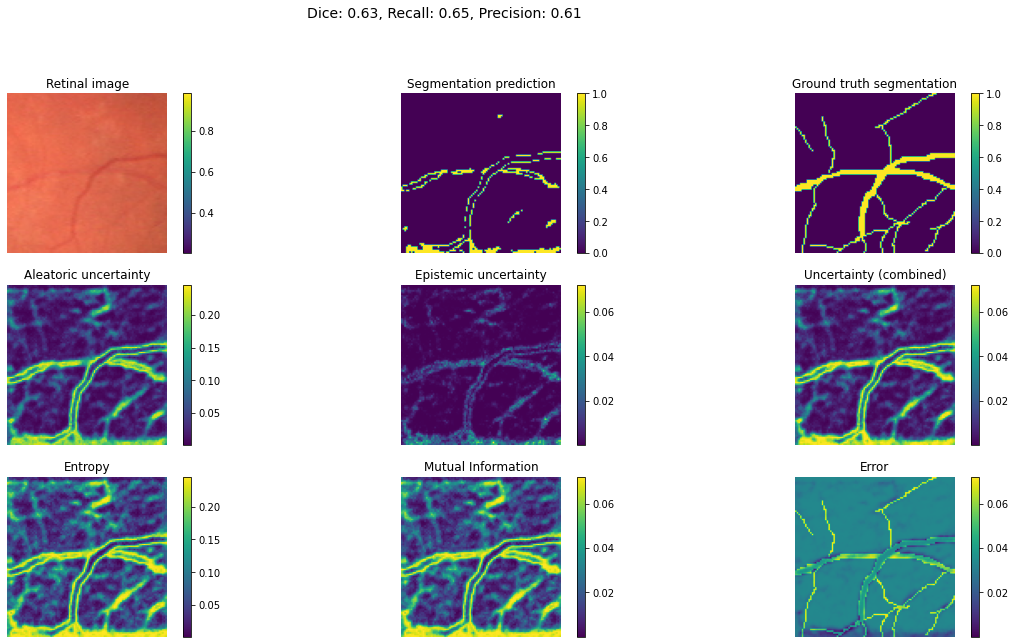

1/1 [==============================] - 0s 11ms/step


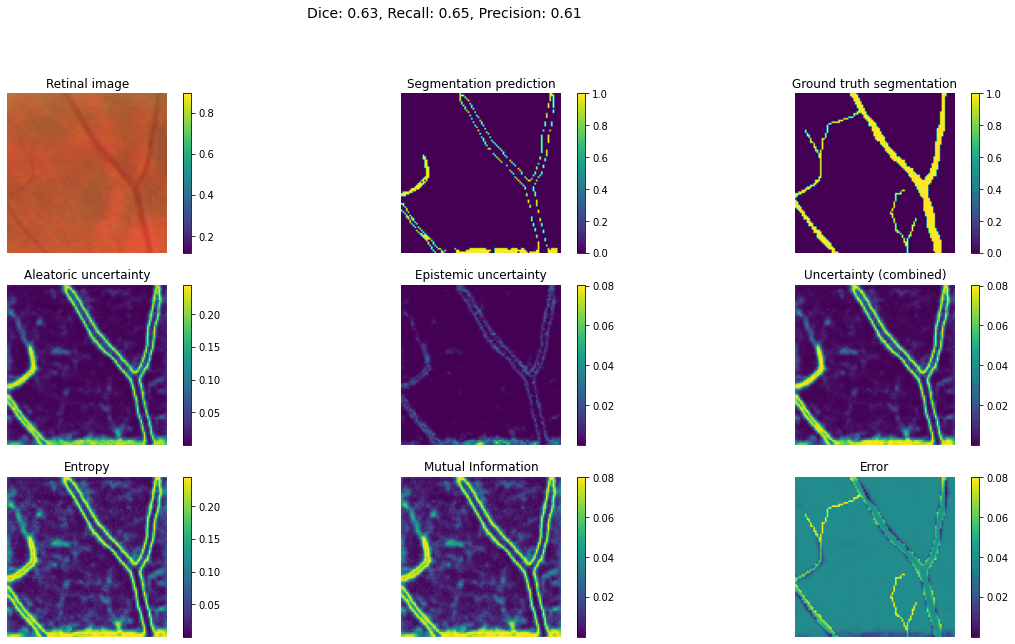

1/1 [==============================] - 0s 10ms/step


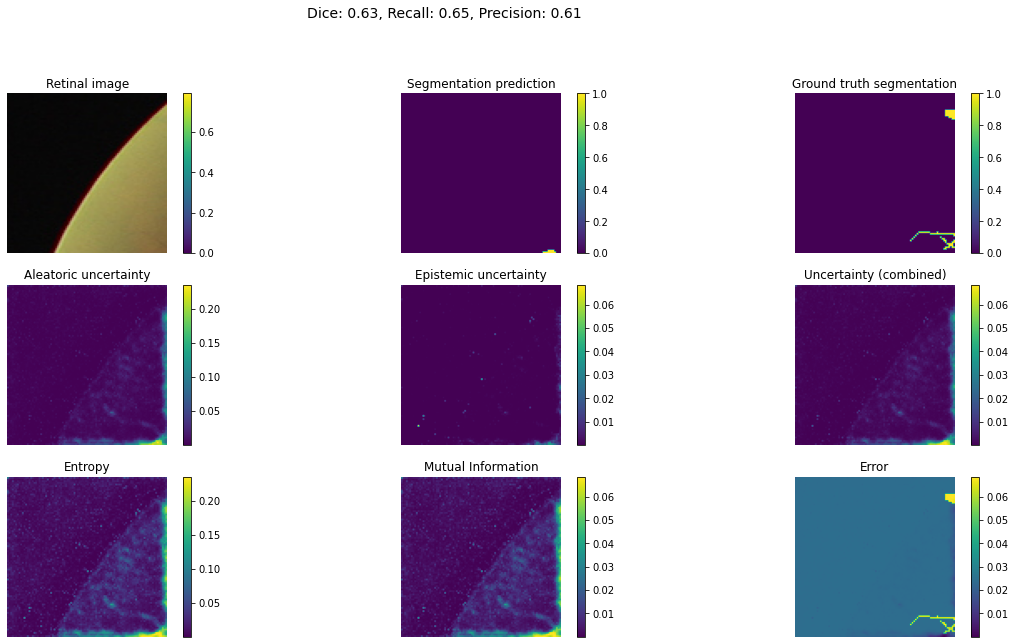

1/1 [==============================] - 0s 11ms/step


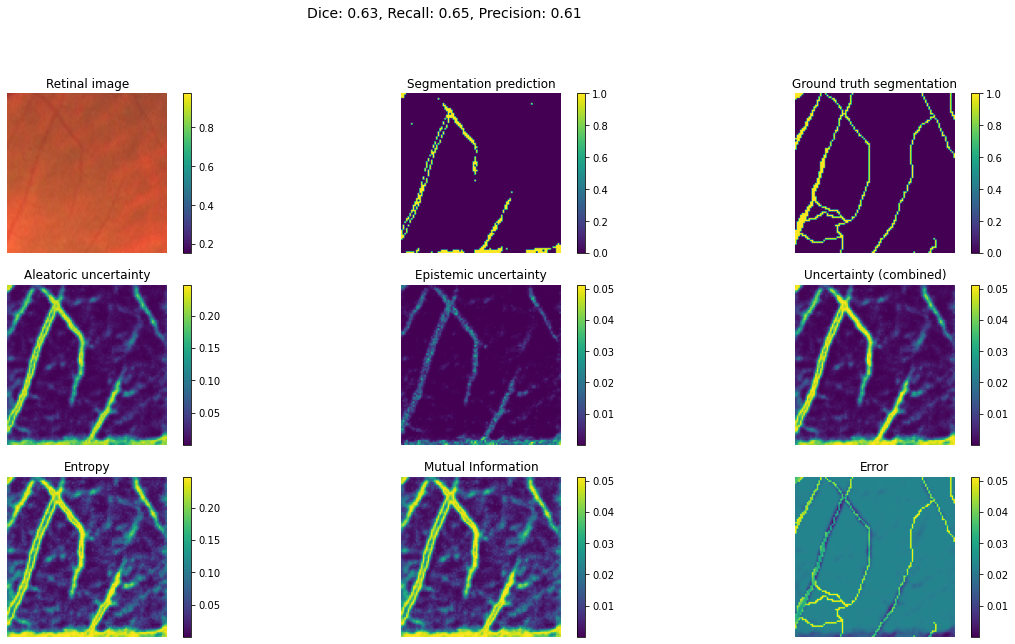

1/1 [==============================] - 0s 12ms/step


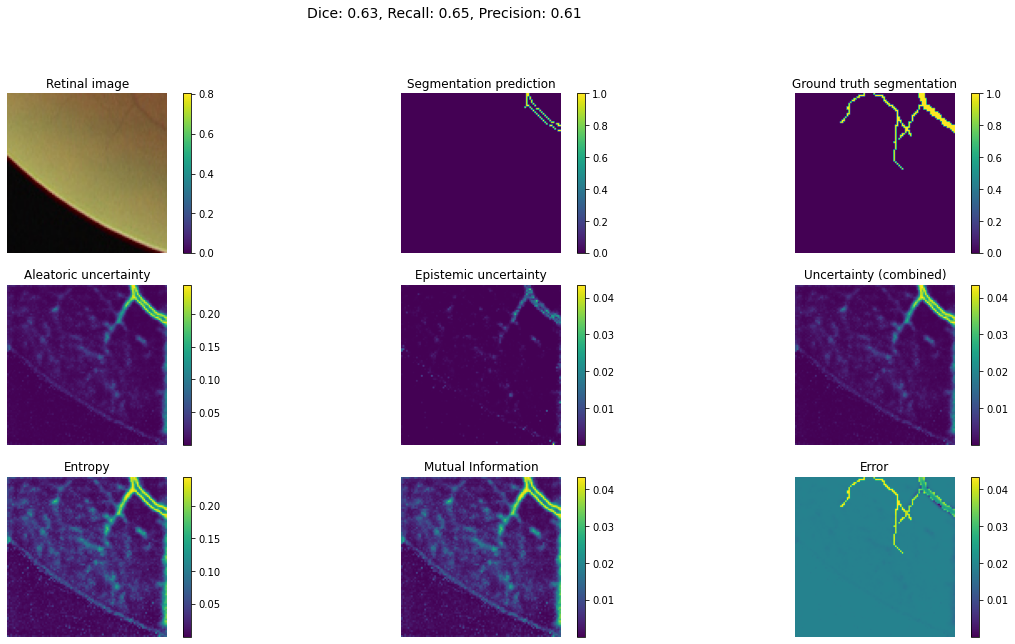

1/1 [==============================] - 0s 10ms/step


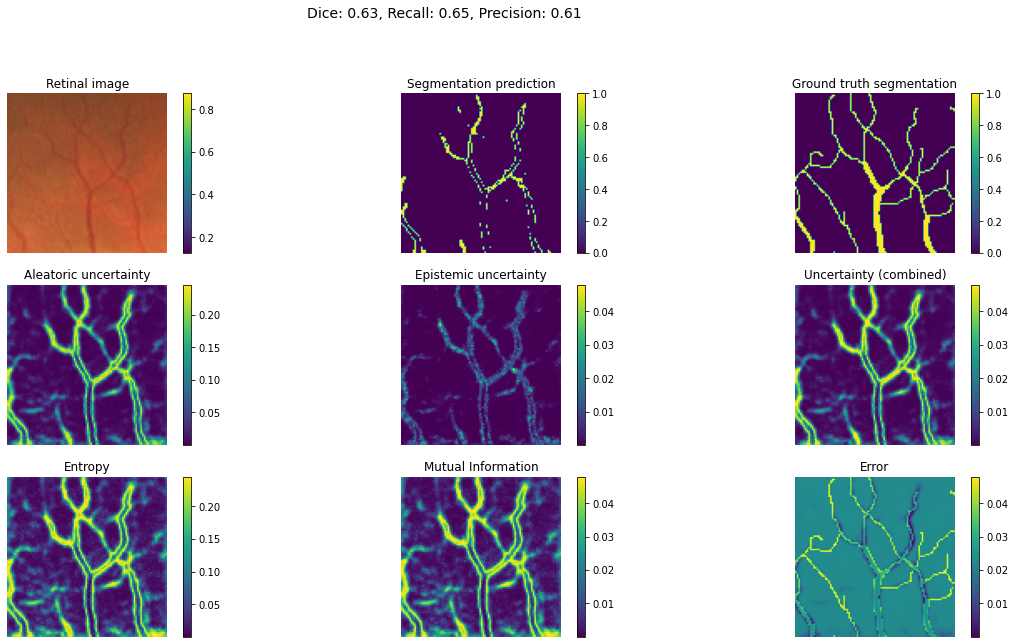

1/1 [==============================] - 0s 10ms/step


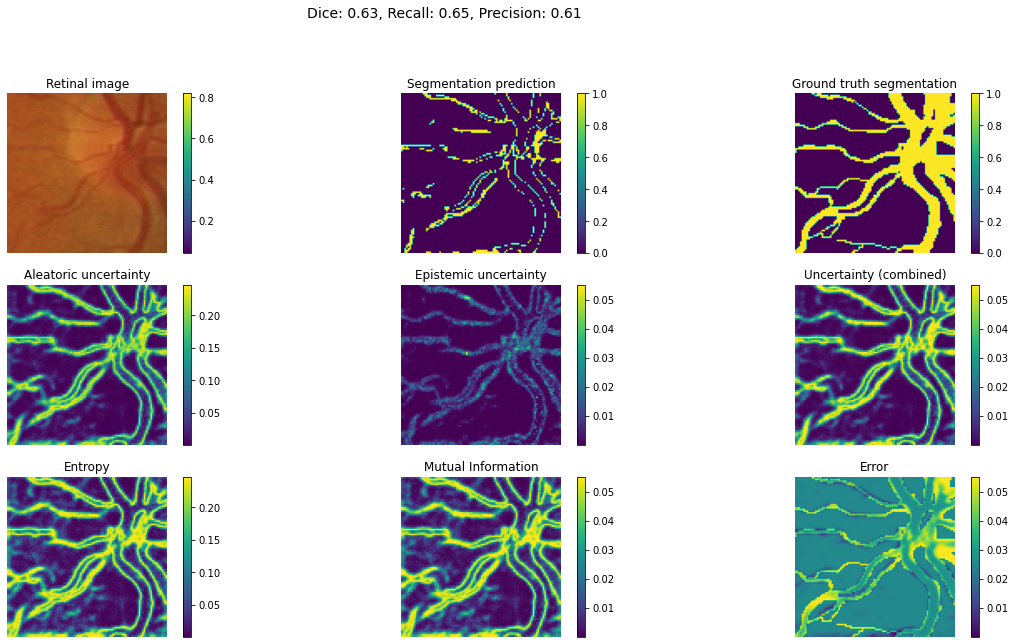

1/1 [==============================] - 0s 13ms/step


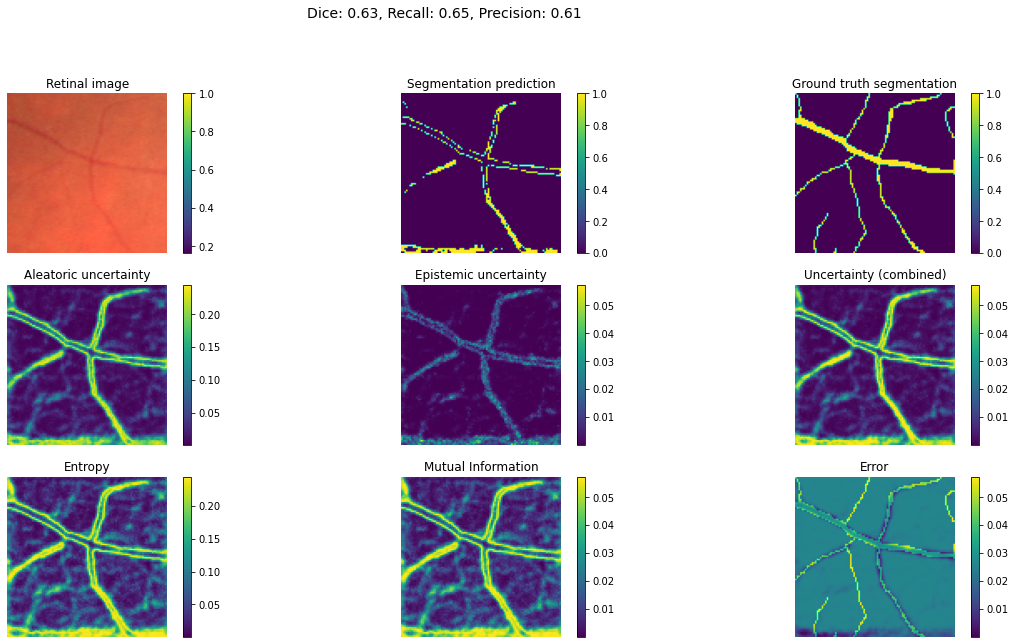

1/1 [==============================] - 0s 9ms/step


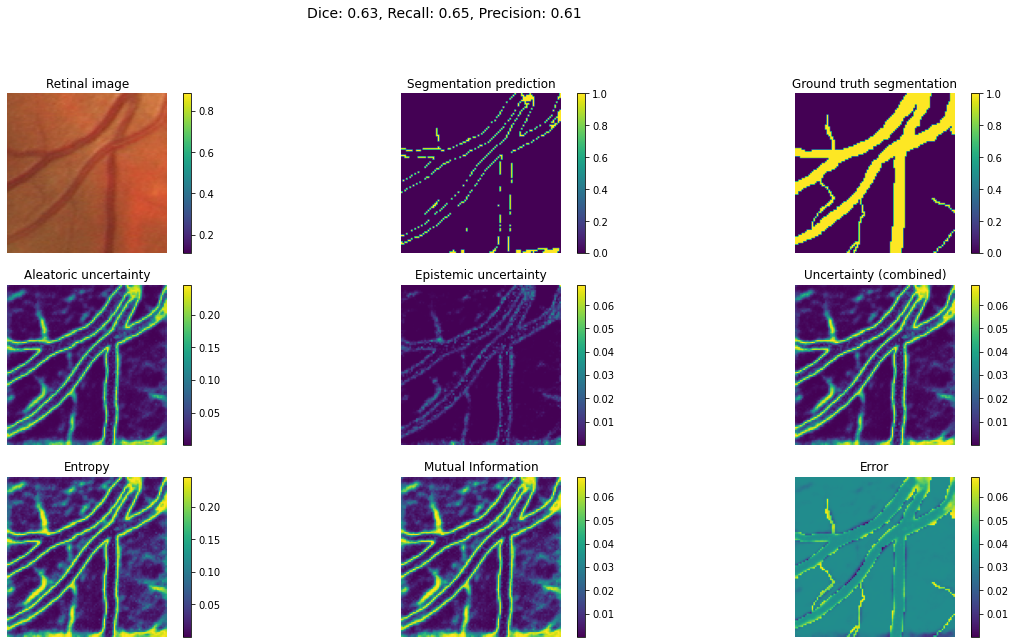

1/1 [==============================] - 0s 10ms/step


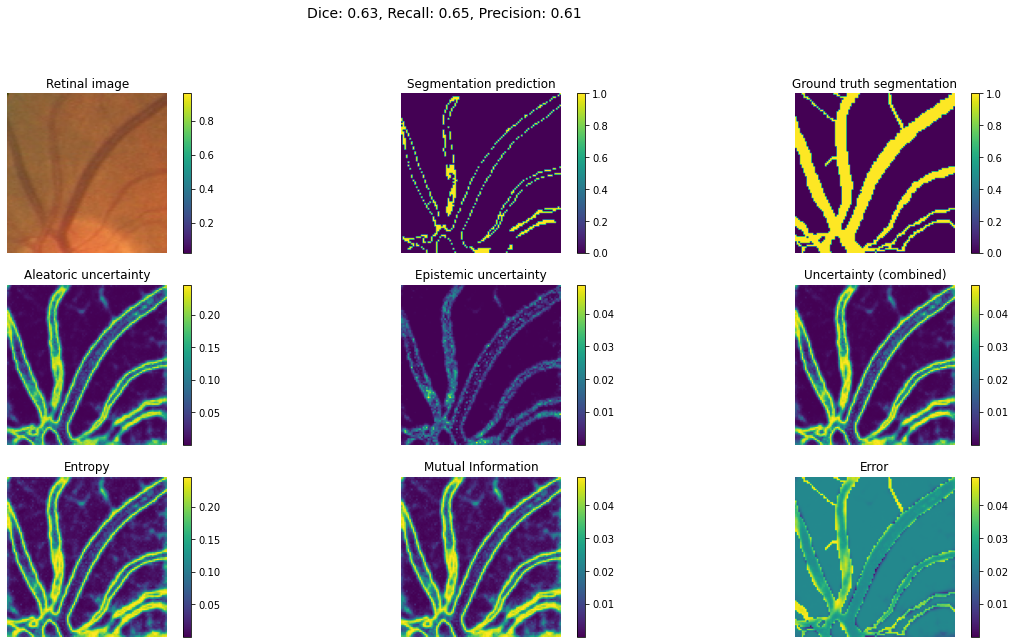

In [ ]:
num = 10
plt.rcParams['image.cmap'] = 'viridis'
import matplotlib.gridspec as gridspec
for i in range(num):
    sample = np.random.randint(0,len(X_predict))
    image = X_predict[sample]
    true  = Y_predict[sample]

    prediction, aleatoric, epistemic, entropy, mi, variance, error, scores = inference(model, image, true , N=10, tau=0.9)
    true     = np.squeeze(true)

    n = np.random.randint(0,num)
    fig, ax = plt.subplots(3,3,figsize=(20,10))

    _, bin_acc, dice, recall, precision, iou_smooth,iou_loss_core  = score
    fig.suptitle('Dice: {:.2f}, Recall: {:.2f}, Precision: {:.2f}\n'.format(dice, recall, precision), y=1.0, fontsize=14)

    cax0 = ax[0,0].imshow(image)
    plt.colorbar(cax0, ax=ax[0,0])
    ax[0,0].set_title('Retinal image')

    cax1 = ax[0,1].imshow(prediction)
    plt.colorbar(cax1, ax=ax[0,1])
    ax[0,1].set_title('Segmentation prediction')

    cax2 = ax[0,2].imshow(true )
    plt.colorbar(cax2, ax=ax[0,2])
    ax[0,2].set_title('Ground truth segmentation')

    cax3 = ax[1,0].imshow(aleatoric)
    plt.colorbar(cax3, ax=ax[1,0])
    ax[1,0].set_title('Aleatoric uncertainty')

    cax4 = ax[1,1].imshow(epistemic)
    plt.colorbar(cax4, ax=ax[1,1])
    ax[1,1].set_title('Epistemic uncertainty')

    cax5 = ax[1,2].imshow(aleatoric+epistemic)
    plt.colorbar(cax4, ax=ax[1,2])
    ax[1,2].set_title('Uncertainty (combined)')


    cax6 = ax[2,0].imshow(entropy)
    plt.colorbar(cax3, ax=ax[2,0])
    ax[2,0].set_title('Entropy')

    cax7 = ax[2,1].imshow(mi)
    plt.colorbar(cax4, ax=ax[2,1])
    ax[2,1].set_title('Mutual Information')

    cax8 = ax[2,2].imshow(error)
    plt.colorbar(cax4, ax=ax[2,2])
    ax[2,2].set_title('Error')
    for a in ax.flatten(): a.axis('off')

    fig.savefig('prediction_uncertainty_{:03d}.png'.format(i), dpi=300)
    plt.show()
    plt.close()

The U-Net has difficulty segmenting the narrower vessels. We see that aleatoric uncertainty and entropy give similar performance, and likewise for  mutual information and the combination of uncertainty (aleatoric + epistemic). However, the epistemic uncertainty clearly represents the areas where the model has difficulty on the narrower vessels. The best method incorporates the U-Net with epistemic uncertainty

In [ ]:
import time
num = len(X_test)
MC_stochastic = [3,5,10,15,20,30]
uncertainty = {}

for idx, samples in enumerate(MC_stochastic):
    start = time.time()
    # UNCERTAINTY METRICS
    aleatoric_list = []
    epistemic_list = []
    entropy_list=[]
    mi_list=[]
    variance_list=[]
    error_list=[]
    dice_list=[]


    for i in range(5):
        image = X_test[i]
        gt    = Y_test[i]
        prediction, aleatoric, epistemic, entropy, mi, variance, error,scores  = inference(model, image, gt, N=samples, tau=0.01)
        gt=np.reshape(gt,(96, 96))

        aleatoric_list.append(np.mean(aleatoric))
        epistemic_list.append(np.mean(epistemic))
        error_list.append(np.mean(error))
        entropy_list.append(np.mean(entropy))
        mi_list.append(np.mean(mi))
        variance_list.append(np.mean(variance))
        dice_list.append(scores[0])

    end = time.time()

    uncertainty.update({ '{}'.format(str(samples)) :
    [samples, (end-start)/num,
     np.mean(aleatoric_list), np.std(aleatoric_list),
     np.mean(epistemic_list), np.std(epistemic_list),
     np.mean(entropy_list), np.std(entropy_list),
     np.mean(mi_list), np.std(mi_list),
     np.mean(variance_list), np.std(variance_list),
     np.mean(error_list), np.std(error_list),
     np.mean(dice_list), np.std(dice_list)
    ]} )

1/1 [==============================] - 0s 8ms/step


We compare different numbers of Monte Carlo samples, from one to thirty stochastic forward passes

In [ ]:
results = np.zeros((13, len(MC_stochastic)))
for idx,samples  in enumerate(MC_stochastic):
    results[:, idx] = uncertainty[str(samples)][1:14]

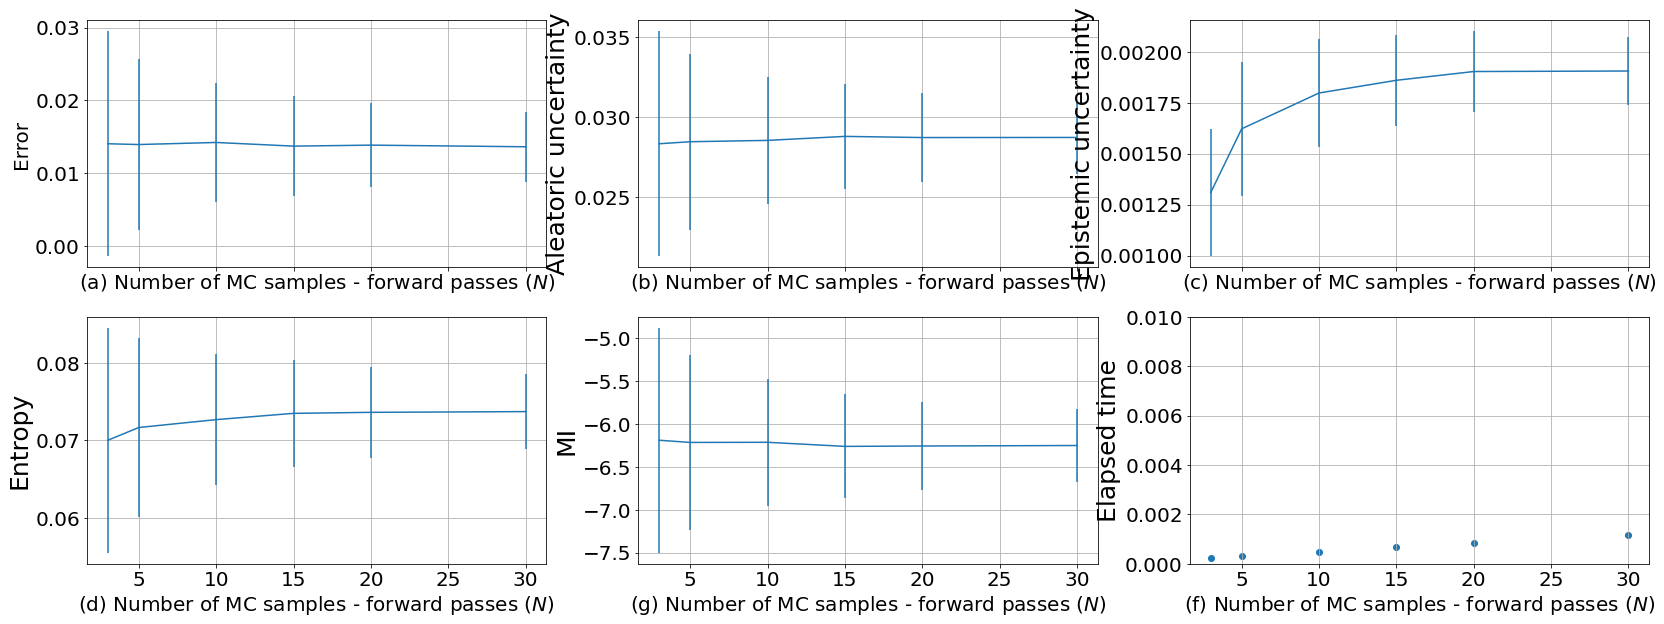

In [ ]:
plt.rcParams.update({'font.size': 20})
f=25
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(28,10), sharex=True)
ax[0,0].grid()
ax[0,1].grid()
ax[0,2].grid()
ax[1,0].grid()
ax[1,1].grid()
ax[1,2].grid()
ax[1,2].scatter(MC_stochastic,results[0])
ax[1,2].grid()
ax[1,2].set_ylabel('Elapsed time',fontsize=f)
ax[1,2].grid()
ax[0,1].errorbar(MC_stochastic,results[1], yerr=results[2]/np.sqrt(MC_stochastic))
ax[0,1].set_ylabel('Aleatoric uncertainty',fontsize=f)
ax[0,2].errorbar(MC_stochastic,results[3], yerr=results[4]/np.sqrt(MC_stochastic))
ax[0,2].set_ylabel('Epistemic uncertainty',fontsize=f)
ax[1,0].errorbar(MC_stochastic,results[5], yerr=results[6]/np.sqrt(MC_stochastic))
ax[1,0].set_ylabel('Entropy', fontsize=f)
ax[1,1].errorbar(MC_stochastic,results[7], yerr=results[8]/np.sqrt(MC_stochastic))
ax[1,1].set_ylabel('MI',fontsize=f)
ax[0,0].errorbar(MC_stochastic,results[11], yerr=results[12]/np.sqrt(MC_stochastic))
ax[0,0].set_ylabel('Error')
ax[0,0].set_xlabel('(a) Number of MC samples - forward passes ($N$)')
ax[0,1].set_xlabel('(b) Number of MC samples - forward passes ($N$)')
ax[0,2].set_xlabel('(c) Number of MC samples - forward passes ($N$)')
ax[1,0].set_xlabel('(d) Number of MC samples - forward passes ($N$)')
ax[1,1].set_xlabel('(e) Number of MC samples - forward passes ($N$)')
ax[1,2].set_xlabel('(f) Number of MC samples - forward passes ($N$)')
ax[1,1].set_xlabel('(g) Number of MC samples - forward passes ($N$)')
ax[1,2].set_ylim(0.00,0.01)
plt.savefig('TimeMC.png',dpi=300)

Since 20 samples indicates a stability point in the metrics, we use it to analyze the performance for retinal vessel segmentation.

# Uncertainty threshold ($\tau$) evaluation: what is the best threshold to refer cases to a medical expert

The uncertainty threshold $\tau$ refers to the percentage of the maximum uncertainty, above which the cases exceeding the uncertainty threshold are referred to a medical professional.

As the threshold increases fewer cases are referred and more cases are predicted on - despite the potential uncertainty

In [ ]:
from keras import metrics as metrics
def inference(model, image, y_true, N=10, tau=0.01):

    # add batch dimension
    image = np.expand_dims(image, 0)
    y_true = np.expand_dims(y_true , 0)

    # perform N stochastic forward passes and then append the preds
    preds = []
    for n in range(N):
        pred=model.predict(image)[0]
        preds.append(pred)
    preds = np.array(preds)

    # calculate the uncertainty metrics
    prediction, entropy, mutual_info, variance, aleatoric,epistemic, overall =  calc_Uncertainty(preds)

    # calculate the accuracy metrics
    loss, bin_acc, dice, precision, recall, iou,iou_loss  = model.evaluate(image, y_true, batch_size=1)
    error=y_true[0]-prediction

    # THRESHOLDING BASED ON UNCERTAINTY

    #############################################################################
    #
    # This will be used to flag cases to a doctor for referral
    #
    ##############################################################################

    prediction = np.where(overall > tau*np.max(overall), 1, 0)

    return np.squeeze(prediction), np.squeeze(aleatoric), np.squeeze(epistemic),np.squeeze(entropy), np.squeeze(mutual_info),np.squeeze(variance), np.squeeze(error), (dice, precision, recall)

In [ ]:
from sklearn import metrics
num = len(X_test)
tau_list=[0.1,0.3,0.5,0.6, 0.7,0.9] # different values of tau to test
metrics_dict={}

for idx, Tau in enumerate(tau_list):
    start = time.time()

    # RESULTS
    mse_list=[]
    roc_auc_list=[]
    brier_list=[]
    f1_list=[]
    precision_list=[]
    recall_list=[]
    zero_one_list=[]
    acc_list=[]

    for i in range(5):
        image = X_test[i]
        gt    = Y_test[i]
        prediction, aleatoric, epistemic, entropy, mi, variance, error,scores  = inference(model, image, gt, N=10, tau=Tau)

        gt=np.reshape(gt,(96, 96))

        mse_list.append(metrics.mean_squared_error(prediction.flatten(), gt.flatten()))
        roc_auc_list.append(metrics.roc_auc_score(prediction.flatten().round(), gt.flatten()))
        brier_list.append(metrics.brier_score_loss(prediction.flatten(), gt.flatten()))
        f1_list.append(metrics.f1_score(prediction.flatten().round(), gt.flatten()))
        precision_list.append(metrics.precision_score(prediction.flatten().round(), gt.flatten()))
        recall_list.append(metrics.recall_score(prediction.flatten().round(), gt.flatten()))
        zero_one_list.append(metrics.zero_one_loss(prediction.flatten().round(), gt.flatten()))
        acc_list.append(metrics.accuracy_score(prediction.flatten().round(), gt.flatten()))


    end = time.time()


    metrics_dict.update({ '{}'.format(str(Tau)) :
    [Tau, (end-start)/num,
     np.mean(roc_auc_list), np.std(roc_auc_list),
     np.mean(precision_list), np.std(precision_list),
     np.mean(recall_list), np.std(recall_list),
     np.mean(acc_list), np.std(acc_list)
    ]} )

1/1 [==============================] - 0s 10ms/step


In [ ]:
results = np.zeros((9, len(tau_list)))
for idx,samples  in enumerate(tau_list):
    results[:, idx] = metrics_dict[str(samples)][1:16]

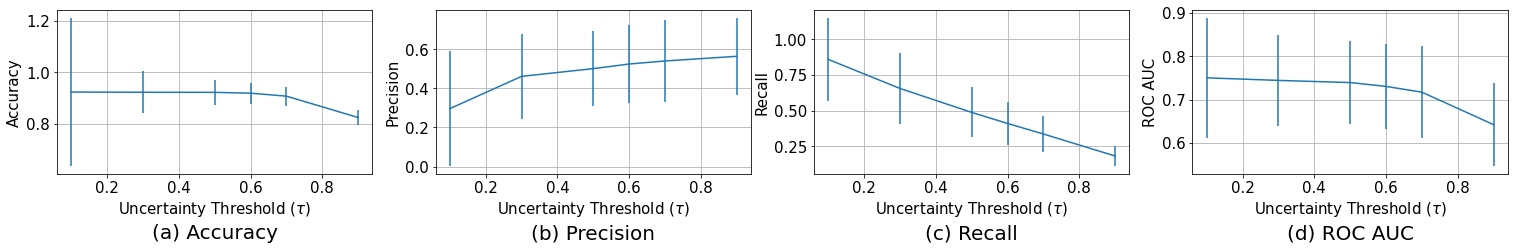

In [ ]:
fsize=15
plt.rcParams.update({'font.size': fsize})
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,  figsize=(26,3), sharex=True)
ax1.errorbar(tau_list,results[7][::-1], yerr=results[8]/np.sqrt(tau_list))
ax1.grid()
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("Uncertainty Threshold " +r'$(\tau)$')
ax1.text(0.5,-0.4, "(a) Accuracy", size=20, ha="center",
         transform=ax1.transAxes)
ax2.errorbar(tau_list,results[5], yerr=results[6]/np.sqrt(tau_list))
ax2.grid()
ax2.set_ylabel("Precision")
ax2.set_xlabel("Uncertainty Threshold " +r'$(\tau)$')
ax2.text(0.5,-0.4, "(b) Precision", size=20, ha="center",
         transform=ax2.transAxes)
ax3.errorbar(tau_list,results[3], yerr=results[4]/np.sqrt(tau_list))
ax3.grid()
ax3.set_ylabel("Recall")
ax3.set_xlabel("Uncertainty Threshold " +r'$(\tau)$')
ax3.text(0.5,-0.4, "(c) Recall", size=20, ha="center",
         transform=ax3.transAxes)
ax4.errorbar(tau_list,results[1][::-1], yerr=results[2]/np.sqrt(tau_list))
ax4.grid()
ax4.set_ylabel("ROC AUC")
ax4.set_xlabel("Uncertainty Threshold " +r'$(\tau)$')
ax4.text(0.5,-0.4, "(d) ROC AUC", size=20, ha="center",
         transform=ax4.transAxes)
fig.savefig('metrics_s.png', dpi=300)

plt.show()
plt.close()

Thus, we propose that a threshold ($\tau$) of 0.6 would best "safest" performance whilst predicting on most cases. This threshold would mean only highly uncertain cases would require medical intervention. Ultimately, meaning safer usage of ML systems within the medical space by leveraging uncertainty.

# Conclusion & Future Work

In summary, we present a framework for uncertainty representation in healthcare, evaluated against a biomedical image segmentation task. The framework indicates the viability of uncertainty representations using MCU-Net combined with epistemic uncertainty to represent areas where the model is uncertain. Additionally, incorporating an uncertainty threshold would allow challenging cases with high uncertainty to be automatically referred to a medical-professional-in-the-loop.

These promising initial results present opportunities for future research. The framework could be applied on other models and application areas within healthcare both for classification and regression problems. This work is a step in the right direction towards uncertainty being leveraged for safe and transparent usage of machine learning in healthcare.


# References

[1]Y. Gal and Z. Ghahramani.  Dropout as a bayesian approximation:  Insights and applications.  In Deep Learning Workshop, ICML, volume 1, page 2, 2015.134

[2]Y. Gal, J. Hron, and A. Kendall. Concrete dropout. In I. Guyon, U. V. Luxburg, S. Bengio, H. Wallach,R. Fergus, S. Vishwanathan, and R. Garnett, editors,Advances in Neural Information Processing Systems, pages 3581–3590. Curran Associates, Inc., 2017.137

[3]K. He, X. Zhang, S. Ren, and J. Sun. Delving deep into rectifiers: Surpassing human-level performance on imagenet classification. InProceedings of the IEEE international conference on computer vision, pages1391026–1034, 2015.140

[4]A. Kendall and Y. Gal.  What uncertainties do we need in bayesian deep learning for computer vision, In I. Guyon, U. V. Luxburg, S. Bengio, H. Wallach, R. Fergus, S. Vishwanathan, and R. Garnett, editors,Advances in Neural Information Processing Systems 30, pages 5574–5584. Curran Associates, Inc., 2017.143

[5]Y. Kwon, J.-H. Won, B. J. Kim, and M. C. Paik. Uncertainty quantification using bayesian neural networks in classification: Application to ischemic stroke lesion segmentation. 2018.145

[6]G. Litjens, T. Kooi, B. E. Bejnordi, A. A. A. Setio, F. Ciompi, M. Ghafoorian, J. A. Van Der Laak,B. Van Ginneken, and C. I. Sánchez. A survey on deep learning in medical image analysis.Medical image analysis, 42:60–88, 2017.148

[7]  D. J. MacKay.Information theory, inference and learning algorithms. Cambridge university press, 2003.149

[8]W. Maddox,  T. Garipov,  P. Izmailov,  D. Vetrov,  and A. G. Wilson.   A simple baseline for bayesian uncertainty in deep learning.arXiv preprint arXiv:1902.02476, 2019.151

[9]A. Nguyen, J. Yosinski, and J. Clune. Deep neural networks are easily fooled: High confidence predictions152for unrecognizable images.   InProceedings of the IEEE conference on computer vision and pattern recognition, pages 427–436, 2015.154

[10]T. Pearce, M. Zaki, A. Brintrup, and A. Neely.  Uncertainty in neural networks:  Bayesian ensembling.CoRR, abs/1810.05546, 2018.156

[11]O. Ronneberger, P. Fischer, and T. Brox. U-net: Convolutional networks for biomedical image segmentation.InInternational Conference on Medical image computing and computer-assisted intervention, pages 234–158241. Springer, 2015.159

[12]K. Shridhar, F. Laumann, and M. Liwicki.  A comprehensive guide to bayesian convolutional neural network with variational inference.CoRR, abs/1901.02731, 2019.161

[13]J. Staal, M. D. Abramoff, M. Niemeijer, M. A. Viergever, and B. van Ginneken.  Ridge-based vessel segmentation in color images of the retina.IEEE Transactions on Medical Imaging, 23(4):501–509, April1632004

[14]A.  Graves.   Practical  variational  inference  for  neural  networks.   InAdvances in neural informationprocessing systems, pages 2348–2356, 2011.

[15]M. Welling and Y. W. Teh. Bayesian learning via stochastic gradient langevin dynamics. InProceedings ofthe 28th international conference on machine learning (ICML-11), pages 681–688, 2011.